In [1]:

import pymol
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import sympy
from pymol import cmd
import pickle
from ired import gen_cov,block_ired
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

In [14]:
import numpy as np
import numpy.linalg as la
from MDAnalysis import Universe


def gen_cov(uni, atom1, atom2, length, shift=False):
    """
    params:
        uni: MDAnalysis Universe object.
        atom1, atom2: Atom names (e.g., 'N', 'C', 'CA', 'CB', etc.).
        length: Expected number of residues in the structure.
        shift: Boolean, True when calculating shifted vectors (e.g., N-C across residues).
    """
    # Load the structure into MDAnalysis
    u = uni

    # Extract coordinates for the specified atoms
    atom1_sel = u.select_atoms(f"resid 1:{length} and name {atom1}")
    atom2_sel = u.select_atoms(f"resid 1:{length} and name {atom2}")

    # Ensure both selections have matching residue indices
    atom1_resids = [atom.resid for atom in atom1_sel]
    atom2_resids = [atom.resid for atom in atom2_sel]
    index_atom1 = [i for i in range(1, length + 1) if i in atom1_resids]
    index_atom2 = [i for i in range(1, length + 1) if i in atom2_resids]

    index = sorted(set(index_atom1).union(set(index_atom2)))

    # Extract coordinates as numpy arrays
    atom1_coords = atom1_sel.positions
    atom2_coords = atom2_sel.positions

    if shift and atom1 == 'N' and atom2 == 'C':
        bond_vec = atom1_coords[1:] - atom2_coords[:-1]
        index = index_atom2[:-1]
    elif shift and atom1 == 'C' and atom2 == 'N':
        bond_vec = atom2_coords[1:] - atom1_coords[:-1]
        index = index_atom1[:-1]
    else:
        bond_vec = atom1_coords[:len(atom2_coords)] - atom2_coords
        index = index_atom2

    # Normalize bond vectors
    normalized_bond_vec = bond_vec / la.norm(bond_vec, axis=1).reshape(-1, 1)

    # Compute cosine similarity matrix
    cos = normalized_bond_vec @ normalized_bond_vec.T

    # Compute covariance matrix
    cov = 0.5 * (3 * cos**2 - 1)

    return np.array(index), cov

In [5]:
#/usres/yunyao_1/Dropbox/KcsA/kcsa_0111/snapshots
import os
import MDAnalysis
pdb_dir='/Users/yunyao_1/Dropbox/KcsA/kcsa_100ns_0111/snapshots_prot'
pdb_container={}
for pdb in os.listdir(pdb_dir):
    pdb_f=os.path.join(pdb_dir,pdb)
    #MDAnalysis.Universe(pdb_f)
    if 'pdb' in pdb_f:
        pdb_container[pdb[23:].rstrip('.pdb')]=MDAnalysis.Universe(pdb_f)

In [23]:
#pdb_container['1'].residues.resids
# test gen_cov
index,cov=gen_cov(pdb_container['1'],'O','C',160)
cov.shape

ranked_pdb_container = dict(sorted(pdb_container.items(), key=lambda x: int(x[0]), reverse=False))
print(ranked_pdb_container.keys())

# for key,pdb_uni in pdb_container.items()[:3]:
#     print(pdb_uni)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

In [25]:
atom1_c = 'o'
atom2_c = 'c'
length_c = 412
shift_c=False
cov_ensemble_nc = []
for i, (key, values) in tqdm(zip(range(1000), ranked_pdb_container.items())):
    cov_ensemble_nc.append(gen_cov(values,'C','O',length_c,shift=shift_c)[1])

1000it [00:08, 119.04it/s]


In [31]:
cov_ensemble_co = np.array(cov_ensemble_nc)
cov_ensemble_co.shape

(1000, 412, 412)

In [30]:
def block_ired_sep(cov_ensemble,block_size,index,total_time=1000,M=0):
    i = 0
    kappa = []
    while i+block_size <= total_time:
        kappa_tmp =[]
        angle = np.array(cov_ensemble[i:i+block_size]).mean(axis=0)
        w, v = la.eig(angle)
        for m in range(len(index)):
#             print(v[:,m].T @ v[:,m])
            kappak=[]
            kappak.append(1/len(index)*np.exp(-(v[:,m]**2 * np.log(v[:,m]**2)).sum()))
            kappa_tmp.append(kappak)
        kappa.append(kappa_tmp) 
        i += block_size
    return np.array(kappa).mean(axis=2)

# NC

In [33]:
index_c=gen_cov(pdb_container['1'],'C','O',412)[0]
block= [10,20,50,100,200,500]
s2_c_list = [block_ired(cov_ensemble_co,block_size,index_c,total_time=1000,M=5)[0] for block_size in block]
err_c_list = [block_ired(cov_ensemble_co,block_size,index_c,total_time=1000,M=5)[2] for block_size in block]

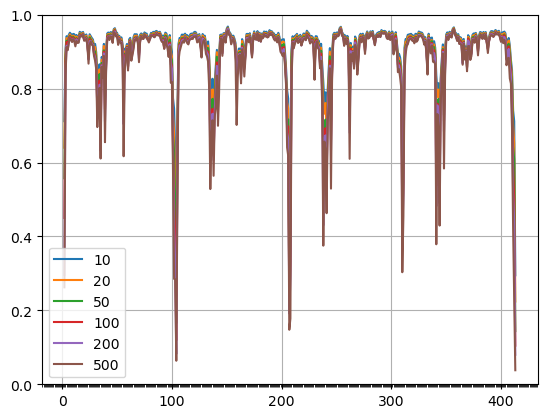

In [34]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax = plt.subplots()
for i,s2 in enumerate(s2_c_list):
    ax.plot(index_c+1,s2,label=block[i])
ax.set_ylim(0.0,1.0)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()
ax.grid()

In [43]:
print(index_c)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

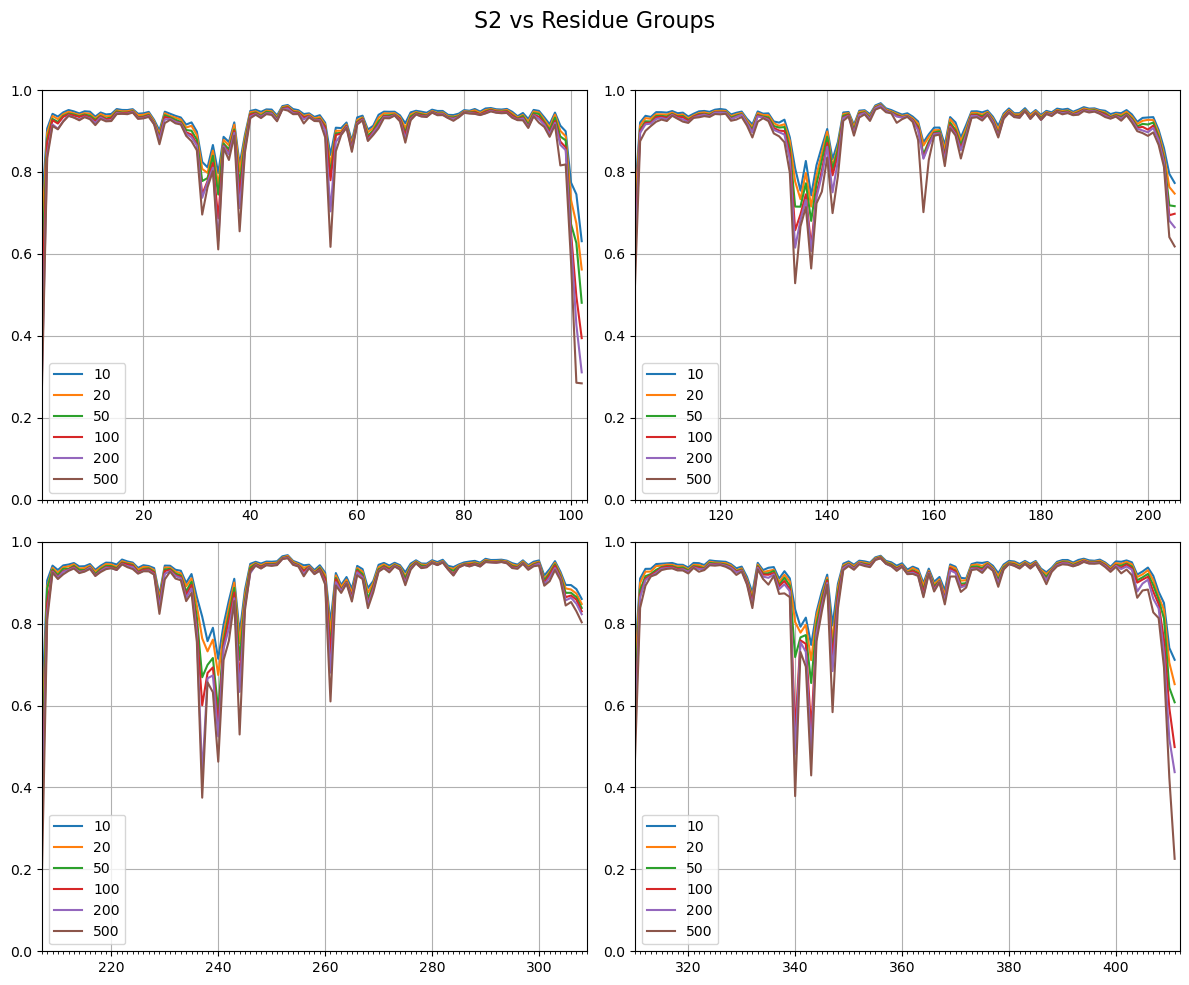

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Assuming s2_c_list and index_c are defined and contain your data
# block is also assumed to be defined, if not, replace with your appropriate labels

# Create the figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define the residue ranges for each plot (22-125, 126-229, etc.)
residue_groups = [
    (22, 124),  # First group: residues from 22 to 125
    (125, 227), # Second group: residues from 126 to 229
    (228, 330), # Third group: residues from 230 to 333
    (331, 433)  # Fourth group: residues from 334 to 437
]

# Iterate through each subplot
for ax, (start, end) in zip(axes.flat, residue_groups):
    for i, s2 in enumerate(s2_c_list):
        # Only plot the data for residues in the current range
        ax.plot(index_c[start-22:end-22], s2[start-22:end-22], label=block[i])  # Adjust index_c and s2 slices
    ax.set_ylim(0.0, 1.0)
    ax.set_xlim(start-21,end-21)  # Set the x-axis limits for the current group
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.legend()
    ax.grid()

# Add a main title for the whole figure
fig.suptitle('S2 vs Residue Groups', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top space for the suptitle
plt.savefig('s2_vs_residue_groups.pdf')
plt.show()


# NCA